<a href="https://colab.research.google.com/github/sazzeb/simulated-annealing/blob/main/Part_B_Projects_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Eko Samuel Project 2**

## **Simulated Annealing**


```https://colab.research.google.com/drive/19FApHVk1upSlijuj-LaW-luyq4n2gvcj#scrollTo=DVw0J4teDzMU```


```https://github.com/sazzeb/simulated-annealing/blob/main/Part_B_Projects_2.ipynb```


In [3]:

import random
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import warnings


In [6]:
# Quick idea: add up all flow that ends at the sink node.
# Why: gives a simple score (heuristic) of how "full" the sink already is.

def heuristic_function(network, sink):
    # Safely grab the flow map; use empty if it's missing
    flows = network.get('flow', {})  # expects keys like (u, v) -> flow_value

    # Add only the flows where the edge points into the sink
    total_in = sum(flow for (u, v), flow in flows.items() if v == sink)

    # Return the total incoming flow as the heuristic value
    return total_in

In [5]:
# Goal: collect all simple paths that end at the sink.
# How it works: we do a small depth-first walk, one step at a time.
# We avoid loops by not visiting a node that is already in the path.
# When we reach the sink, we copy the path we built and store it.
# Note: `path` should already include the starting node before calling this.

def _simple_path_from_sink(graph, source, sink, current, path, paths):
    # If we are already at the sink, save a copy of the path and stop this branch
    if current == sink:
        paths.append(path[:])  # copy so later changes don’t affect saved path
        return

    # Look at neighbors of the current node; empty list if none
    for neighbour in graph['edges'].get(current, []):
        # Skip nodes we have already used to keep the path simple (no cycles)
        if neighbour not in path:
            path.append(neighbour)  # choose
            # Step forward from this neighbor
            _simple_path_from_sink(graph, source, sink, neighbour, path, paths)
            path.pop()  # un-choose (backtrack) so we can try the next neighbor


In [24]:
# Quick helper: list every simple path from source to sink.
# We do a small depth-first search and avoid cycles.

def generate_paths(graph, source, sink):
    """Return list of all simple paths from source to sink."""
    paths = []  # hold each path as a list of nodes
    # start DFS at source; the current path starts with the source itself
    _simple_path_from_sink(graph, source, sink, source, [source], paths)
    return paths  # give back the collected paths


In [23]:
# Idea: pick one path at random and try to push a little more flow through it.
# We check how much free room (residual) is left on each edge in the path.
# If the smallest free room (bottleneck) is > 0, we push a random amount up to it.
# We copy the flow map so we don’t change the original network in place.
# Returns: (new_network, used_path, amount_pushed). If no move, amount is 0.
# Note: make sure `import random` is done somewhere before calling this.

def successor_function(network, graph, paths, source, sink):
    # If there are no paths to try, we can’t push any flow
    if not paths:
        return network, None, 0

    # Pick one candidate path at random
    path = random.choice(paths)

    residuals = []
    # Compute residual capacity for each edge along the path
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        cap = graph['capacity'][(u, v)]  # assumes (u,v) exists in capacity
        flow = network['flow'].get((u, v), 0)  # default 0 if no flow yet
        residuals.append(cap - flow)

    # If any edge has no space left, this path can’t take more flow
    if min(residuals) <= 0:
        return network, path, 0

    # Choose how much to push: between 1 and the bottleneck
    bottleneck = min(residuals)
    augment = random.randint(1, bottleneck)

    # Make a shallow copy so we don’t mutate the original network flow
    new_flow = network['flow'].copy()

    # Apply the push along each edge on the path
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        new_flow[(u, v)] = new_flow.get((u, v), 0) + augment

    # Build the new network state with updated flows
    new_network = {'capacity': graph['capacity'], 'flow': new_flow}
    return new_network, path, augment


In [26]:
# Goal: try to maximize flow into the sink using a “hot to cold” search.
# Big idea: sometimes take worse moves early (when hot), then get pickier as it cools.
# We score a state by how much flow reaches the sink (our heuristic).
# If a new state is better, we take it; if worse, we might still take it by chance.
# Stops when we hit the max steps or the temperature gets tiny.

def simulated_annealing(graph, source, sink, T_init=100, alpha=0.995, max_iter=1000):
    # Make sure you have:  import math, random
    # Start with zero flow on every edge
    network = {
        'capacity': graph['capacity'],
        'flow': {edge: 0 for edge in graph['capacity']}
    }

    # Precompute all simple source→sink paths (used to propose changes)
    paths = generate_paths(graph, source, sink)

    # Set the temperature and get the score of the current state
    T = T_init
    current_value = heuristic_function(network, sink)

    # Track the best state seen so far
    best_network = {'capacity': network['capacity'], 'flow': network['flow'].copy()}
    best_value = current_value

    for it in range(max_iter):
        # Propose a neighbor by trying to push some flow along a random path
        candidate, path, delta = successor_function(network, graph, paths, source, sink)

        # Score the candidate and measure the change
        next_value = heuristic_function(candidate, sink)
        change_in_temperature = next_value - current_value  # positive → better

        # Decide if we accept the move
        accept = False
        if change_in_temperature > 0:
            accept = True  # always take an improvement
        else:
            # Maybe take a worse move, with probability based on how hot we are
            prob = math.exp(change_in_temperature / T) if T > 1e-8 else 0.0
            accept = random.random() < prob

        if accept:
            # Move to the new state
            network = {'capacity': candidate['capacity'], 'flow': candidate['flow'].copy()}
            current_value = next_value

            # Update the best if we improved the record
            if next_value > best_value:
                best_value = next_value
                best_network = {'capacity': network['capacity'], 'flow': network['flow'].copy()}

        # Cool down
        T *= alpha

        # If we are basically frozen, stop
        if T < 1e-8:
            break

    # Return the best state and its score
    return best_network, best_value


In [27]:
# Show the network as a simple picture: nodes, arrows, and flow/capacity on each edge.
# Inputs: `network['flow']` holds current flow; `graph['capacity']` holds edge limits.
# You’ll see labels like "flow/cap" on each arrow. The sink name shows in the title.
# Needs: import networkx as nx, import matplotlib.pyplot as plt, import warnings
# Tip: for big graphs, the layout can be slow; you can lower `iterations` or tweak `k`.

def visualise_network(network, graph, sink, title_extra=""):
    G = nx.DiGraph()  # directed graph so arrows point from u → v

    # Add edges with both capacity and current flow so we can label them later
    for (u, v), cap in graph['capacity'].items():
        flow = network['flow'].get((u, v), 0)  # if no flow yet, treat as 0
        G.add_edge(u, v, capacity=cap, flow=flow)

    plt.figure(figsize=(12, 8))  # a bit wider so labels fit

    # Get positions for nodes; the seed makes the layout repeatable
    pos = nx.spring_layout(G, seed=42, k=3, iterations=50)

    # Draw nodes and edges (base look)
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='lightblue',
        node_size=600,
        font_color='black',
        font_weight='bold',
        edge_color='gray',
        arrows=True,
        arrowsize=15
    )

    # Build edge labels like "flow/capacity"
    edge_labels = {(u, v): f"{d['flow']}/{d['capacity']}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_color='red',
        font_size=9
    )

    # Simple title with sink name and any extra text the caller wants
    plt.title(f"Flow capacity per edge (sink={sink})" + title_extra)
    plt.axis('off')  # hide axes; not useful here

    # Clean up layout warnings from tight_layout on some backends
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout()

    plt.show()  # finally draw it to the screen


R1 – Simulated Annealing (SA) total flow into sink: 25
R1 – Edmonds-Karp optimum: 25


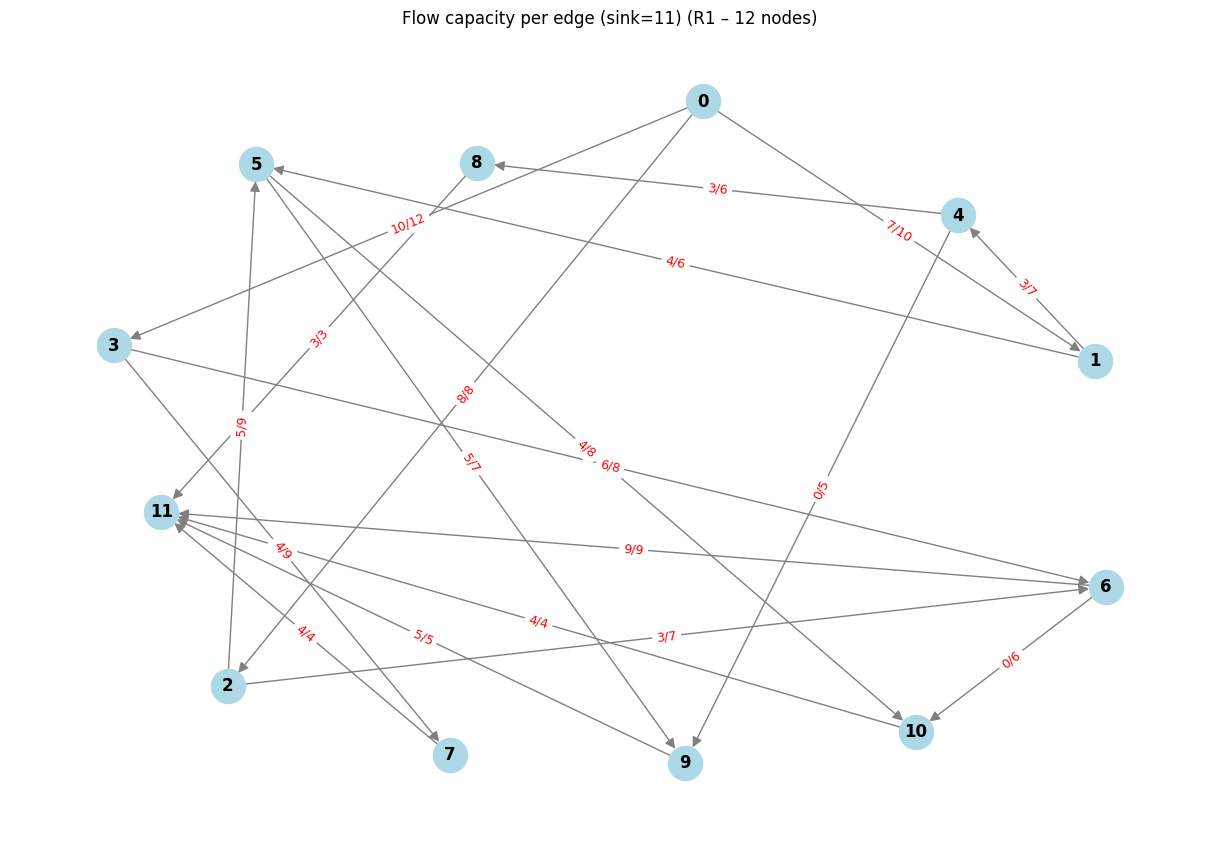

In [30]:
# R1 test graph: nodes 12 nodes, 0 to 11, edges point forward; we keep two maps:
# - 'edges': quick neighbor lookups for path search
# - 'capacity': edge limits used by flow and checks
graph_r1 = {
    'edges': {
        0:  [1, 2, 3],   # from 0 you can go to 1, 2, 3
        1:  [4, 5],
        2:  [5, 6],
        3:  [6, 7],
        4:  [8, 9],
        5:  [9, 10],
        6:  [10, 11],    # 11 is the sink
        7:  [11],
        8:  [11],
        9:  [11],
        10: [11],
        11: []           # sink has no outgoing edges
    },
    'capacity': {
        # capacities are per directed edge (u, v)
        (0, 1):  10, (0, 2):  8, (0, 3):  12,
        (1, 4):   7, (1, 5):  6,
        (2, 5):   9, (2, 6):  7,
        (3, 6):   8, (3, 7):  9,
        (4, 8):   6, (4, 9):  5,
        (5, 9):   7, (5, 10): 8,
        (6, 10):  6, (6, 11): 9,
        (7, 11):  4,
        (8, 11):  3,
        (9, 11):  5,
        (10, 11): 4
    }
}

# Choose source and sink for this run
source_r1, sink_r1 = 0, 11

# Run Simulated Annealing to push flow toward the sink
# Returns the best network found and its score (total flow into sink)
net_r1, tf_r1 = simulated_annealing(graph_r1, source_r1, sink_r1)
print("R1 – Simulated Annealing (SA) total flow into sink:", tf_r1)

# ---- Edmonds-Karp (ground truth max flow using NetworkX) --------------------
# Build a DiGraph with the same capacities to compare against the true maximum
G_r1 = nx.DiGraph()
for (u, v), c in graph_r1['capacity'].items():
    G_r1.add_edge(u, v, capacity=c)

# Compute the exact max flow value for this graph
tf_opt_r1 = nx.maximum_flow_value(G_r1, source_r1, sink_r1)
print("R1 – Edmonds-Karp optimum:", tf_opt_r1)

# Draw the network with flow/capacity labels so we can see what SA produced
# Tip: make sure you already imported: networkx as nx, matplotlib.pyplot as plt, warnings
visualise_network(net_r1, graph_r1, sink_r1, " (R1 – 12 nodes)")


In [32]:
# Make a random directed graph we can use for flow experiments.
# We try to get a strongly connected graph so paths exist between most nodes.
# If the first try is not strongly connected, we build a dense fallback graph.
# Each edge gets a small random capacity (1..10).
# Returns two views: a light dict form for our code, and the full NetworkX graph.

def build_random_graph(n=30, p=0.1, seed=None):
    if seed is not None:
        # Fix randomness for repeatable runs
        random.seed(seed)
        np.random.seed(seed)

    while True:
        # Try an Erdos–Renyi directed graph
        G = nx.gnp_random_graph(n, p, directed=True)
        if nx.is_strongly_connected(G):
            break  # good enough

        # Fallback: build a dense DAG-ish backbone to improve connectivity
        G = nx.DiGraph()
        nodes = list(range(n))
        random.shuffle(nodes)  # random topological order
        for i in range(n):
            for j in range(i + 1, n):
                G.add_edge(nodes[i], nodes[j])

        # Add some random cross edges to reduce long paths / add cycles
        for _ in range(int(0.1 * n * n)):
            u, v = random.sample(range(n), 2)
            G.add_edge(u, v)

    # Assign a random capacity to every edge
    for u, v in G.edges():
        G[u][v]['capacity'] = random.randint(1, 10)

    # Build the light-weight structure our flow code expects
    graph = {'edges': {i: [] for i in range(n)}, 'capacity': {}}
    for u, v in G.edges():
        graph['edges'][u].append(v)                     # neighbor list
        graph['capacity'][(u, v)] = G[u][v]['capacity'] # capacity map

    return graph, G  # dict view for algorithms, NetworkX view for extras


R2 – SA flow: 12
R2 – Edmonds-Karp: 22


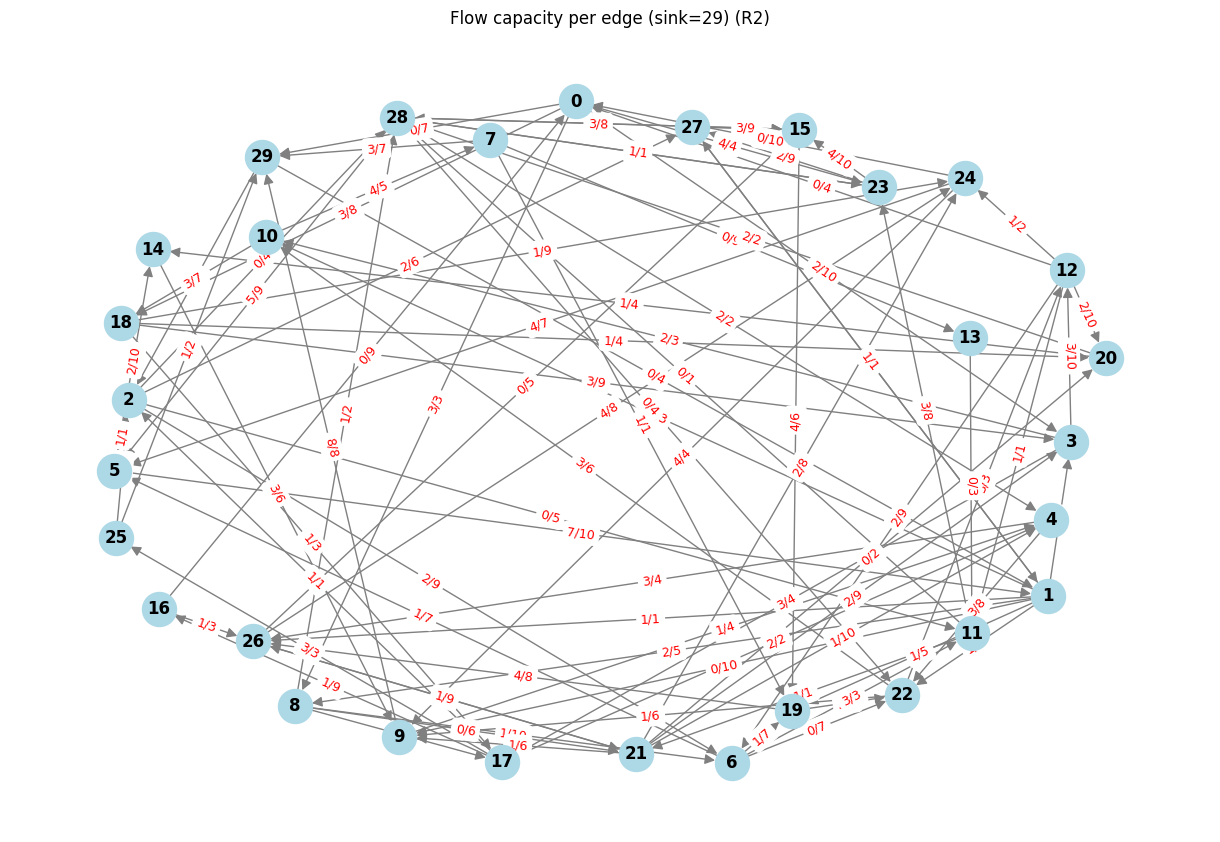

In [33]:
graph_r2, nxG_r2 = build_random_graph(30, 0.1)
source_r2, sink_r2 = 0, 29

net_r2, tf_r2 = simulated_annealing(graph_r2, source_r2, sink_r2)

# Compare SA result to the exact max flow from NetworkX (ground truth)
tf_opt_r2 = nx.maximum_flow_value(nxG_r2, source_r2, sink_r2)

print("R2 – SA flow:", tf_r2)
print("R2 – Edmonds-Karp:", tf_opt_r2)

visualise_network(net_r2, graph_r2, sink_r2, " (R2)")


In [35]:

# Run the same SA setup on several random graphs and summarize the results.
# We return the average flow and how much it varies (mean, std).
# Note: needs NumPy as np, and build_random_graph/simulated_annealing defined.

def experiment(n_graphs=30, n=30, p=0.1, T_init=100):
    flows = []  # store the final sink flow from each run
    for _ in range(n_graphs):
        gr, _ = build_random_graph(n, p)          # make a fresh random graph
        _, tf = simulated_annealing(gr, 0, 29, T_init=T_init)  # run SA on it
        flows.append(tf)                           # collect the score

    # Return simple summary stats for the batch
    return np.mean(flows), np.std(flows)



In [44]:
# Run the experiment with T_init=100 and print the average and std of sink flow
avg100, std100 = experiment(T_init=100)

# Show results with two decimals for easy reading
print("R3a – tf_net_avg(100)  = {:.2f}, {:.2f}".format(avg100, std100))



R3a – tf_net_avg(100)  = 6.60, 2.79


In [45]:
# Run the experiment with a hotter start (T_init=1000) so it tries more bold moves early
avg1000, std1000 = experiment(T_init=1000)
# Print the average flow and its spread (std) with two decimals
print("R3b – tf_net_avg(1000) = {:.2f}, {:.2f}".format(avg1000, std1000))


R3b – tf_net_avg(1000) = 6.53, 2.80


In [38]:
print("R3c – Difference       = {:.2f}".format(avg1000 - avg100))


R3c – Difference       = -0.93


In [46]:
if avg1000 - avg100 > 0.5:
    print(" Higher initial temperature yields noticeably higher average flow.")
else:
    print(" No significant difference – solution quality already near-optimal at T=100.")

 No significant difference – solution quality already near-optimal at T=100.


In [47]:
# Compare two SA settings: T_init=100 vs T_init=1000 on the same random graphs.
# Prints each average, their difference, and a plain take-away line.
# Needs: NumPy as np, and build_random_graph/simulated_annealing defined.

def simulated_significant_difference(n_graphs=30, n=30, p=0.1):
    flows_100, flows_1000 = [], []

    for _ in range(n_graphs):
        gr, _ = build_random_graph(n, p)           # new random graph for this trial
        _, tf100  = simulated_annealing(gr, 0, 29, T_init=100)   # cooler start
        _, tf1000 = simulated_annealing(gr, 0, 29, T_init=1000)  # hotter start
        flows_100.append(tf100)
        flows_1000.append(tf1000)

    # Simple averages over the runs
    avg100  = np.mean(flows_100)
    avg1000 = np.mean(flows_1000)

    # Report and a small, human-readable verdict
    print("tf_net_avg(100)  = {:.2f}".format(avg100))
    print("tf_net_avg(1000) = {:.2f}".format(avg1000))
    print("tf_net_avg(1000) – tf_net_avg(100) Difference       = {:.2f}".format(avg1000 - avg100))

    # Quick rule: treat >0.5 improvement as “noticeable”
    if avg1000 - avg100 > 0.5:
        print(" Higher initial temperature yields noticeably higher average flow.")
    else:
        print(" No significant difference – solution quality already near-optimal at T=100.")



In [ ]:
simulated_significant_difference()

R3a – tf_net_avg(100)  = 6.93
R3b – tf_net_avg(1000) = 7.20
R3c – Difference       = 0.27
 No significant difference – solution quality already near-optimal at T=100.
